In [ ]:
!pip install datasets
!pip install transformers==4.33.0
!pip install accelerate
!pip install rouge_score

In [ ]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from datasets import Dataset, load_metric
import numpy as np
import nltk


# Transformers
from transformers import BartTokenizer, BartForConditionalGeneration      # BERT Tokenizer and architecture
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments         # These will help us to fine-tune our model
from transformers import pipeline                                         # Pipeline
from transformers import DataCollatorForSeq2Seq                           # DataCollator to batch the data
import torch                                                              # PyTorch
# import evaluate                                                           # Hugging Face's library for model evaluation

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Importing and Preprocessing our dataset
### we wanna limit our number of tokens to less than 1024

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Data/scisumm_new.csv")

In [ ]:
data.head(2)

,Unnamed: 0,text,summary,cleaned_text,cleaned_summary,text_10,text_20,text_sumy_10,text_sumy_20,blue_scores_10,blue_scores_sumy,sim_scores_10,sim_scores_sumy
0,0,TnT - A Statistical Part-Of-Speech Tagger Trig...,TnT - A Statistical Part-Of-Speech Tagger\nTri...,tnt a statistical part-of-speech tagger trigra...,tnt a statistical part-of-speech tagger trigra...,words in the wall street journal part of the p...,words in the wall street journal part of the p...,we describe the basic model of tnt the techni...,contrary to claims found elsewhere in the lit...,0.254836,0.282592,0.376645,0.340122
1,1,Mildly Non-Projective Dependency Structures Sy...,Mildly Non-Projective Dependency Structures\nS...,mildly non-projective dependency structures sy...,mildly non-projective dependency structures sy...,yli-jyrä 2003 proposes multiplanarity as a gen...,yli-jyrä 2003 proposes multiplanarity as a gen...,although such a definition can be useful we d...,in dependency-based parsing several constrain...,0.364817,0.231453,0.366517,0.528158


In [ ]:
def count_words(text):
    return len(text.split())

data['text_10_count'] = data.apply(lambda row: len(str(row["text_10"]).split()), axis=1)
data['text_10_sumy_count'] = data.apply(lambda row: len(str(row["text_sumy_10"]).split()), axis=1)
data['text_20_count'] = data.apply(lambda row: len(str(row["text_20"]).split()), axis=1)
data['text_20_sumy_count'] = data.apply(lambda row: len(str(row["text_sumy_20"]).split()), axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1012 non-null   object 
 1   text                1012 non-null   object 
 2   summary             1012 non-null   object 
 3   cleaned_text        1012 non-null   object 
 4   cleaned_summary     1009 non-null   object 
 5   text_10             1006 non-null   object 
 6   text_20             1006 non-null   object 
 7   text_sumy_10        1005 non-null   object 
 8   text_sumy_20        1005 non-null   object 
 9   blue_scores_10      1008 non-null   float64
 10  blue_scores_sumy    1007 non-null   float64
 11  sim_scores_10       1007 non-null   float64
 12  sim_scores_sumy     1007 non-null   float64
 13  text_10_count       1012 non-null   int64  
 14  text_10_sumy_count  1012 non-null   int64  
 15  text_20_count       1012 non-null   int64  
 16  text_2

In [ ]:
data.dropna(inplace=True)

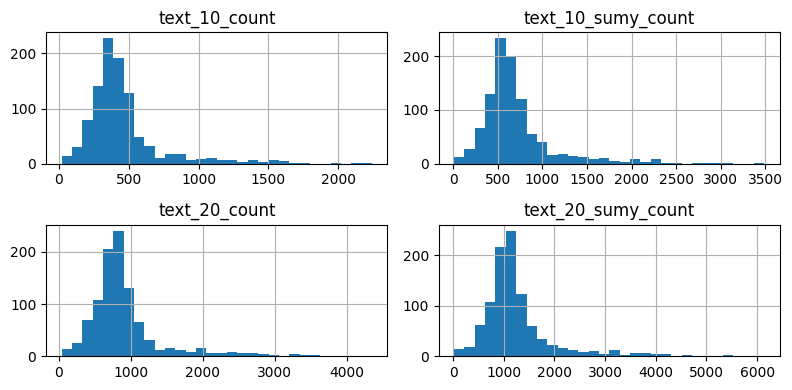

In [ ]:
numerical_columns = data.select_dtypes(include=['int64'])

# Create histograms for all numerical columns
numerical_columns.hist(bins=30, figsize=(8, 4))
plt.tight_layout()  # Ensure proper spacing between plots

plt.show()

### we will be using text 10% since it has the more data

In [ ]:
data_10 = data[data['text_10_count'] < 900]
data_10_sumy = data[data['text_10_sumy_count'] < 900]

data_10 = data_10[["text_10", "cleaned_summary"]]
data_10_sumy = data_10_sumy[['text_sumy_10', 'cleaned_summary']]

In [ ]:
data_10.head(2)

,text_10,cleaned_summary
0,words in the wall street journal part of the p...,tnt a statistical part-of-speech tagger trigra...
1,yli-jyrä 2003 proposes multiplanarity as a gen...,mildly non-projective dependency structures sy...


In [ ]:
data_10_sumy.head(2)

,text_sumy_10,cleaned_summary
0,we describe the basic model of tnt the techni...,tnt a statistical part-of-speech tagger trigra...
1,although such a definition can be useful we d...,mildly non-projective dependency structures sy...


In [ ]:
checkpoint = 'facebook/bart-large-cnn' # Model
tokenizer = BartTokenizer.from_pretrained(checkpoint)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

In [ ]:
model = BartForConditionalGeneration.from_pretrained(checkpoint)

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [ ]:
def preprocess_function_10(examples):
    inputs = [doc for doc in examples["text_10"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["cleaned_summary"], max_length=200, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

def preprocess_function_sumy(examples):
    inputs = [doc for doc in examples["text_sumy_10"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["cleaned_summary"], max_length=200, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
train_percentage = 80


# Use the sample method to randomly select rows
data_10_train = data_10.sample(n=int(len(data_10) * (train_percentage / 100.0)), random_state=42)  # Use a fixed random_state for reproducibility

# Create a DataFrame containing the rows that were not selected in the first DataFrame
data_10_test = data_10.drop(data_10_train.index)

train_ds = Dataset.from_pandas(data_10_train)

test_ds = Dataset.from_pandas(data_10_test)

tokenized_train = train_ds.map(preprocess_function_10, batched=True,
                               remove_columns=['text_10', 'cleaned_summary', '__index_level_0__']) # Removing features
tokenized_test = test_ds.map(preprocess_function_10, batched=True,
                               remove_columns=['text_10', 'cleaned_summary', '__index_level_0__']) # Removing features

# Printing results
print('\n' * 3)
print('Preprocessed Training Dataset:\n')
print(tokenized_train)

# Printing results
print('\n' * 3)
print('Preprocessed Testing Dataset:\n')
print(tokenized_test)

Map:   0%|          | 0/747 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/187 [00:00<?, ? examples/s]





Preprocessed Training Dataset:

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 747
})




Preprocessed Testing Dataset:

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 187
})


In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [ ]:
metric = load_metric('rouge') # Loading ROUGE Score

<ipython-input-19-e481c2b1455f>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('rouge') # Loading ROUGE Score
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred# Obtaining predictions and true labels

    # Decoding predictions
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Obtaining the true labels tokens, while eliminating any possible masked token (i.e., label = -100)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]


    # Computing rouge score
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()} # Extracting some results

    # Add mean-generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir = 'bart_samsum',
    evaluation_strategy = "epoch",
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_loss',
    seed = 42,
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    report_to="none"
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
0,No log,2.889658,44.069900,17.654100,26.269500,39.853500,133.064200
2,2.922700,2.816542,45.208000,18.121400,26.923300,41.287100,137.128300
2,2.309300,2.844035,46.230300,18.764400,27.541200,42.023100,134.304800
3,2.309300,2.887650,45.663100,18.269900,26.794700,41.704500,138.390400


TrainOutput(global_step=1492, training_loss=2.4118613071799597, metrics={'train_runtime': 3305.4682, 'train_samples_per_second': 0.904, 'train_steps_per_second': 0.451, 'total_flos': 3118182052798464.0, 'train_loss': 2.4118613071799597, 'epoch': 3.99})

In [ ]:
# Use the sample method to randomly select rows
data_sumy_train = data_10_sumy.sample(n=int(len(data_10_sumy) * (train_percentage / 100.0)), random_state=42)  # Use a fixed random_state for reproducibility

# Create a DataFrame containing the rows that were not selected in the first DataFrame
data_sumy_test = data_10_sumy.drop(data_sumy_train.index)

train_ds_sumy = Dataset.from_pandas(data_sumy_train)

test_ds_sumy = Dataset.from_pandas(data_sumy_test)

tokenized_train_sumy = train_ds_sumy.map(preprocess_function_sumy, batched=True,
                               remove_columns=['text_sumy_10', 'cleaned_summary', '__index_level_0__']) # Removing features
tokenized_test_sumy = test_ds_sumy.map(preprocess_function_sumy, batched=True,
                               remove_columns=['text_sumy_10', 'cleaned_summary', '__index_level_0__']) # Removing features

# Printing results
print('\n' * 3)
print('Preprocessed Training Dataset:\n')
print(tokenized_train_sumy)

# Printing results
print('\n' * 3)
print('Preprocessed Testing Dataset:\n')
print(tokenized_test_sumy)

Map:   0%|          | 0/664 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/166 [00:00<?, ? examples/s]





Preprocessed Training Dataset:

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 664
})




Preprocessed Testing Dataset:

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 166
})


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_sumy,
    eval_dataset=tokenized_test_sumy,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,2.267937,51.031600,26.288600,34.212900,47.803700,131.668700
2,2.268100,2.254642,51.537800,26.187700,34.311800,48.187900,138.120500
3,2.268100,2.298691,51.605800,25.356700,33.881300,48.034600,137.548200
4,1.809200,2.361352,51.065800,24.971800,33.026200,47.398000,138.060200


TrainOutput(global_step=1328, training_loss=1.904367263058582, metrics={'train_runtime': 3107.5687, 'train_samples_per_second': 0.855, 'train_steps_per_second': 0.427, 'total_flos': 3784704278298624.0, 'train_loss': 1.904367263058582, 'epoch': 4.0})

In [ ]:
# Saving model to a custom directory
directory = "/content/drive/MyDrive/Bart-summarizer"
trainer.save_model(directory)

# Saving model tokenizer
tokenizer.save_pretrained(directory)

('/content/drive/MyDrive/Bart-summarizer/tokenizer_config.json',
 '/content/drive/MyDrive/Bart-summarizer/special_tokens_map.json',
 '/content/drive/MyDrive/Bart-summarizer/vocab.json',
 '/content/drive/MyDrive/Bart-summarizer/merges.txt',
 '/content/drive/MyDrive/Bart-summarizer/added_tokens.json')

In [ ]:
import shutil

shutil.make_archive('/content/drive/MyDrive/Bart-summarizer', 'zip', '/content/drive/MyDrive/Bart-summarizer')

'/content/drive/MyDrive/Bart-summarizer.zip'

In [ ]:
summarizer = pipeline('summarization', model = '/content/drive/MyDrive/Bart-summarizer')

In [ ]:
text = data["text_10"][0]
summary = data["cleaned_summary"][0]
generated_summary = summarizer(text)

In [ ]:
print('Original Dialogue:\n')
print(text)
print('\n' * 2)
print('Reference Summary:\n')
print(summary)
print('\n' * 2)
print('Model-generated Summary:\n')
print(generated_summary)

Original Dialogue:

words in the wall street journal part of the penn treebank ending in able are adjectives .11 in 98% of the cases e.g. without this subtraction the model would overfit the training data and would generally yield worse results. while the viterbi algorithm is guaranteed to find the sequence of states with the highest probability this is no longer true when beam search is added. we use the wall street journal as contained in the penn treebank for our experiments. we use the longest suffix that we can find in the training set i.e. we use the context-independent variant of linear interpolation i.e. we use flags ci that are true if wi is a capitalized word and false otherwise. we set for all i = 0 ... m — 1 using a tagset of s tags and the average 11 this usually yields values in the range 003 ... 0.10. we maintain two different suffix tries depending on the capitalization of the word. we have shown that a tagger based on markov models yields state-of-the-art results despi